In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

from hsic import HSIC
from mcmc_integration import BayesCalibrationMCMC
from metamodels import KarhunenLoeveMetamodel, GpMetamodelInd, VPCEMetamodel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openturns as ot
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

# Paris' law basic forward Euler implementation

## Paris' Law

Paris' law is an empirical relationship that describes the rate of fatigue crack growth in materials. It is used to predict the growth of cracks under cyclic loading conditions. The law is expressed as:

$$ \frac{da}{dN} = C (\Delta K)^m $$

where:
- $ \frac{da}{dN} $ is the crack growth rate per cycle.
- $ C $ is a material constant.
- $ \Delta K $ is the stress intensity factor range.
- $ m $ is the Paris' law exponent.

### Nominal parameters of fictitious material 

- **Material constant ($C$):** $ 1 \times 10^{-10} $
- **Paris' law exponent ($m$):** 3.0
- **Maximum applied stress ($ \sigma_{max} $):** 100.0 MPa
- **Minimum applied stress ($ \sigma_{min} $):** 10.0 MPa
- **Geometry factor ($Y$):** 1.1
- **Initial crack length ($ a_0 $):** 0.001 m
- **Total number of cycles ($N_{\text{cycles}}$):** 1,000,000
- **Step size ($\delta_N$):** 1000 cycles per step
- **Critical crack length ($a_{\text{max}}$):** 0.05 m

### Stress Intensity Factor Range (ΔK)

The stress intensity factor range, $ \Delta K $, is calculated using the formula:

$$ \Delta K = Y (\sigma_{max} - \sigma_{min}) \sqrt{\pi a} $$

where:
- $ Y $ is the geometry factor.
- $ \sigma_{max} $ is the maximum applied stress.
- $ \sigma_{min} $ is the minimum applied stress.
- $ a $ is the crack length.

This notebook will implement a basic forward Euler method to simulate the crack growth over the specified number of cycles.


In [2]:
# Function to compute ΔK
def delta_K(a, sigma_max, sigma_min, Y):
    return Y * (sigma_max - sigma_min) * np.sqrt(np.pi * a)

In [3]:
# Explicit Euler method for Paris' Law
def paris_crack_growth(N_cycles, delta_N, a_max, C, m, sigma_max, sigma_min, Y, a0):
    N_values = [0]  # Store cycle count
    a_values = [a0]  # Store crack lengths
    
    a = a0
    N = 0

    while N < N_cycles and a < a_max:
        # Compute stress intensity factor range
        dK = delta_K(a, sigma_max, sigma_min, Y)
        
        # Paris' law: da/dN = C * (ΔK)^m
        da_dN = C * (dK**m)
        
        # Explicit Euler update
        a_new = a + da_dN * delta_N
        N += delta_N

        # Stop if the crack length exceeds critical limit
        if a_new >= a_max:
            a_values.append(a_max)
            N_values.append(N)
            break

        # Store values       
        N_values.append(N)
        a_values.append(a_new)

        a = a_new

    return np.array(N_values), np.array(a_values)


In [4]:
# Paris' law parameters (fictitious nominal values for a given material)
C = 1e-10  # Material constant 
m = 3.0    # Paris' law exponent

# Load parameters
sigma_max = 100.0  # Maximum applied stress 
sigma_min = 10.0   # Minimum applied stress 
Y = 1.1  # Geometry factor 

# Initial conditions
a0 = 0.001  # Initial crack length in meters
N_cycles = 100e4 # Total number of cycles
delta_N = 1000  # Step size (number of cycles per step)
a_max = 0.05  # Critical crack length 


In [5]:
n_data = [3, 4, 2, 13]

In [6]:
N_values, a_values = paris_crack_growth(N_cycles, delta_N, a_max, C, m, sigma_max, sigma_min, Y, a0)

In [7]:
ot.RandomGenerator.SetSeed(42)
times = [np.sort(np.asarray(ot.Uniform(50000, int(max(N_values))).getSample(n_data[i])).reshape(-1).astype(int)) for i in range(len(n_data))]    

In [8]:
ot.RandomGenerator.SetSeed(45)
values = [np.sort(np.interp(times[i], N_values, a_values) + np.asarray(ot.Normal(0.000,0.001).getSample(len(times[i]))).reshape(1, -1)) for i in range(len(n_data))]

In [9]:
data = [[times[i], values[i]] for i in range(len(n_data))]

# Uncertainty propagation 

In [10]:
C_dist = ot.Uniform(C * 0.9, C * 1.1) 
m_dist = ot.Uniform(m - 0.1, m + 0.1)  
sigma_max_dist = ot.Uniform(sigma_max - 5.0, sigma_max + 5.0)  
sigma_min_dist = ot.Uniform(sigma_min - 1.0, sigma_min + 1.0) 
Y_dist = ot.Uniform(Y - 0.01, Y + 0.01)  
a0_dist = ot.Uniform(a0 - 0.0001, a0 + 0.0001) 

# Create a composed distribution
marginals = [C_dist, m_dist, sigma_max_dist, sigma_min_dist, Y_dist, a0_dist]
prior = ot.ComposedDistribution(marginals)

n_max = 1000  
X = prior.getSample(n_max)


Text(0, 0.5, 'Crack Length (m)')

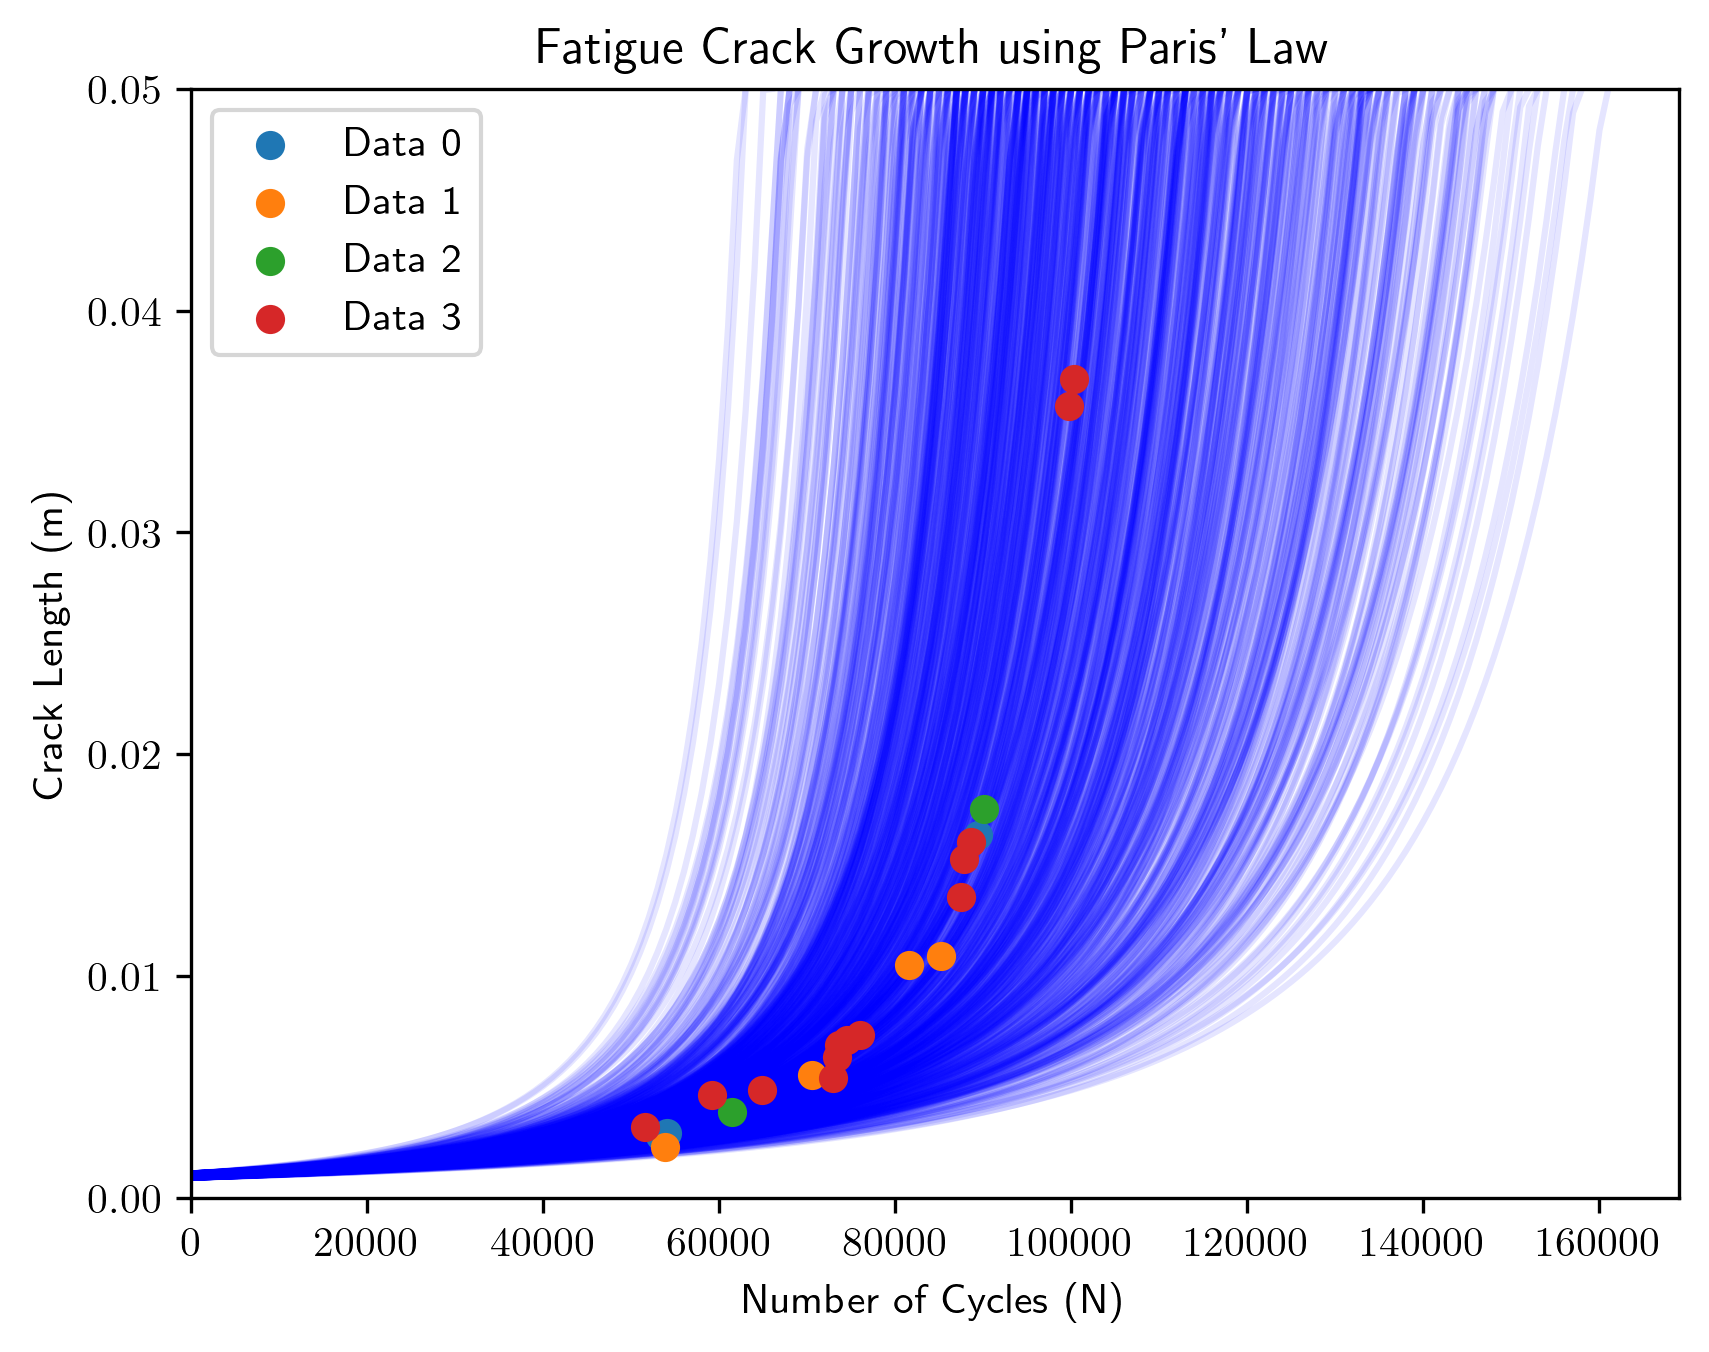

In [11]:
doe = []
for i in range(n_max):
    C, m, sigma_max, sigma_min, Y, a0 = X[i]
    #N_values, a_values = paris_model(X[i])
    N_values, a_values = paris_crack_growth(N_cycles, delta_N, a_max, C, m, sigma_max, sigma_min, Y, a0)
    if np.inf in a_values:
        print(X[i])
    doe.append([N_values, a_values])
    plt.plot(N_values, a_values, color='blue', alpha=0.1)

for i in range(len(data)):
    plt.scatter(data[i][0], data[i][1],  label=f'Data {i}', zorder=10)
plt.xlim(0)
plt.ylim(0, 0.05)
plt.legend()
plt.title("Fatigue Crack Growth using Paris' Law")
plt.xlabel("Number of Cycles (N)")
plt.ylabel("Crack Length (m)")

# Parametric OT function

In [12]:
data_without_time_division = []
for j in range(4):
    for i in range(len(data[j][0])):
        data_without_time_division.append([data[j][0][i], data[j][1][0][i]])
data_without_time_division = np.sort(np.asarray(data_without_time_division), axis=0)

In [13]:
def paris_model(X):
    C, m, sigma_max, sigma_min, Y, a0 = X
    N_vals, res = paris_crack_growth(N_cycles, delta_N, a_max, C, m, sigma_max, sigma_min, Y, a0)
    return np.interp(data_without_time_division[:,0], N_vals, res)

In [14]:
INPUT_DIMENSION = 6
OUTPUT_DIMENSION = len(data_without_time_division[:,0])

In [15]:
paris_func = ot.PythonFunction(INPUT_DIMENSION, OUTPUT_DIMENSION, paris_model)

In [16]:
class ParisMetamodel():
    def __init__(self, metamodel, index: int, ref_points: np.ndarray):
        self.metamodel = metamodel
        self.input_dimension = INPUT_DIMENSION
        self.output_dimension = OUTPUT_DIMENSION
        self.index = index
        self.ref_points = ref_points
        self.input_names = ['C', 'm', 'sigma_max', 'sigma_min', 'Y', 'a0']
        self.output_names = ['Crack Length']
        
    
    def predict(self, X: np.ndarray):
        if self.index is None:
            return self.metamodel(X)
        else:
            indices = [i for i in range(self.input_dimension) if i != self.index]
            output_function = ot.ParametricFunction(self.metamodel, indices, self.ref_points[indices])
            return output_function(X)

In [17]:
ref_points = np.asarray([C, m, sigma_max, sigma_min, Y, a0])

In [18]:
ParisMetamodel(paris_func, 3, ref_points).predict([0.00003])

class=Point name=Unnamed dimension=22 values=[0.00437962,0.00470834,0.00481178,0.00486751,0.00609013,0.00677223,0.00804178,0.0111314,0.0129271,0.0133265,0.0134587,0.0143402,0.0158997,0.0246314,0.0346091,0.0441092,0.0462101,0.0486534,0.05,0.05,0.05,0.05]

# Methodology test
We use the simulation test above and the original function to recreate the DoE. To be noted is that the true model is used at each iteration

In [19]:
def kl_div(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [20]:
data_without_time_division = []
for j in range(4):
    for i in range(len(data[j][0])):
        data_without_time_division.append([data[j][0][i], data[j][1][0][i]])
data_without_time_division = np.sort(np.asarray(data_without_time_division), axis=0)

In [21]:
data_with_time_division = []
for i in range(len(data)):
    data_j = []
    for j in range(len(data[i][0])):
        data_j.append([data[i][0][j], data[i][1][0][j]])
    data_with_time_division.append(np.asarray(data_j))

In [22]:
time_indices = [np.where(np.isin(data_without_time_division[:,0], data_with_time_division[i][:,0]))[0] for i in range(len(data_with_time_division))]


In [23]:
input_dimension = 6
threshold = 0.1
N = 10000

#MCMC parameters
step_sizes = [1e-10, 0.01, 1, 1, 0.0001, 0.0001]

proposal_distribution = [ot.Uniform(-step, step) for step in step_sizes]

posterior_distributions = []

y = np.asarray([np.interp(data_without_time_division[:,0], doe[i][0], doe[i][1]) for i in range(len(doe))])

while True:
    #Compute the max HSIC index
    hsic = HSIC(ot.Sample(X), ot.Sample(y))
    r2_hsic, _ = hsic.r2_hsic()
    index = int(np.where(max(r2_hsic.mean(axis=1)) == r2_hsic.mean(axis=1))[0][0])
    print('HSIC max is for index = ', (index+1))

    # Instantiate the metamodel
    metamodels = [ParisMetamodel(paris_func, index, ref_points)]

    # GP scalers for the index variable
    all_scalers = [None]
    # MCMC posterior distribution
    print('Running MCMC calibration')
    bayes_int = BayesCalibrationMCMC(data=data_with_time_division, data_time_indices=time_indices, metamodels=metamodels, scalers=all_scalers)
    posterior = bayes_int.mcmc_run(support_min=[marginals[index].getRange().getLowerBound()[0]], support_max=[marginals[index].getRange().getUpperBound()[0]], proposal=proposal_distribution[index], burning=100, n_chains=5, sample_size=1000, nb_weights=1)

    # Compute the Kullback divergence
    posterior_samples = np.asarray(posterior.getSample(N)).reshape(-1)
    prior_samples = np.asarray(marginals[index].getSample(N)).reshape(-1)
    posterior_pdf, _ = np.histogram(posterior_samples, bins=100, density=True)
    prior_pdf, _ = np.histogram(prior_samples, bins=100, density=True)
    posterior_pdf = posterior_pdf / np.sum(posterior_pdf)
    prior_pdf = prior_pdf / np.sum(prior_pdf)
    kullback_divergence = kl_div(posterior_pdf, prior_pdf)

    print('Kullback-Leibler divergence = ', kullback_divergence)

    if kullback_divergence < threshold or kullback_divergence == np.inf:
        #the prior is fully informed by the data and the calibration is stopped
        posterior_distributions.append(marginals)
        break
    elif kullback_divergence > threshold:
        #modify the prior distribution
        marginals[index] = posterior
        prior = ot.ComposedDistribution(marginals)
        X = np.asarray(prior.getSample(n_max))
        #Update the design of experiments
        y = ParisMetamodel(paris_func, None, ref_points).predict(X)
        continue

HSIC max is for index =  2
Running MCMC calibration
Only one calibration function
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0108316682202172
Kullback-Leibler divergence =  0.5217062060358266


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_46177/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_46177/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  3
Running MCMC calibration
Only one calibration function
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0033863804546945
Kullback-Leibler divergence =  0.38813073354768113
HSIC max is for index =  1
Running MCMC calibration
Only one calibration function
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0009259447322856
Kullback-Leibler divergence =  0.40532423463368866
HSIC max is for index =  2
Running MCMC calibration
Only one calibration function
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0021704277647403
Kullback-Leibler divergence =  inf


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_46177/1849261530.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_46177/1849261530.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


# Results visualization

Text(0.5, 0.98, "Paris' Law with prior distributions and after assimilation ")

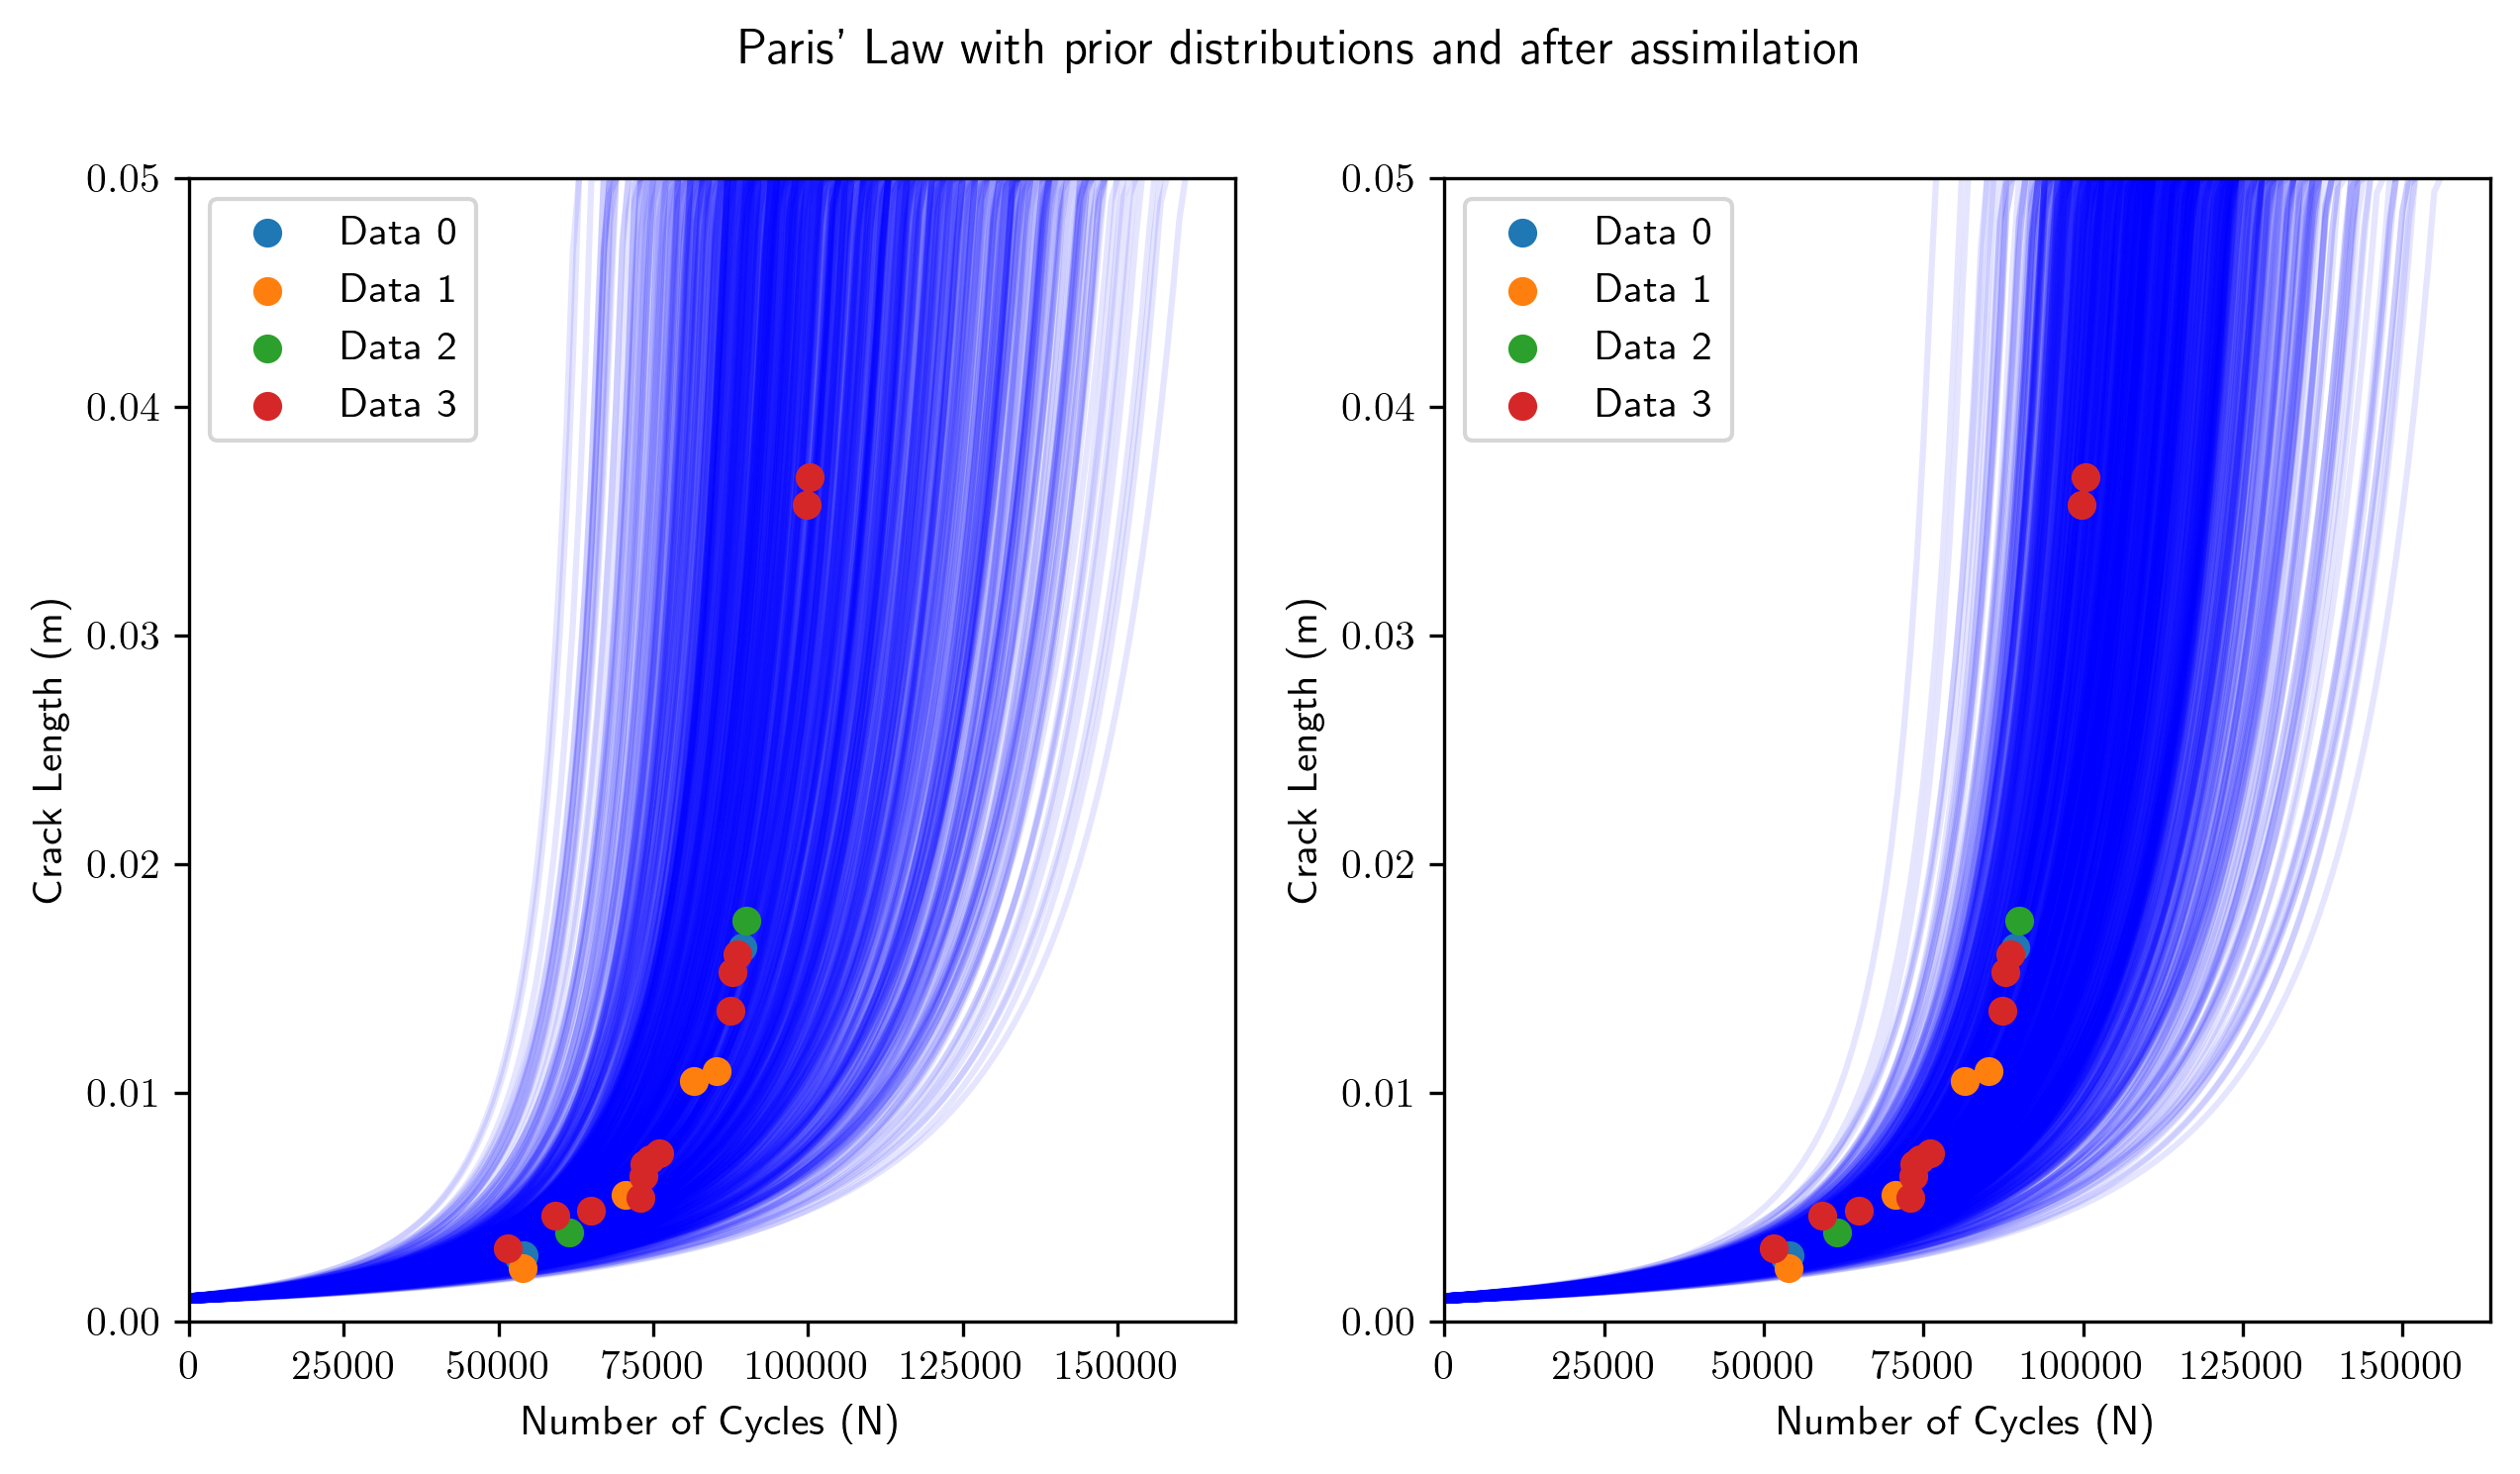

In [24]:
res = []
X = prior.getSample(n_max)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(n_max):
    C, m, sigma_max, sigma_min, Y, a0 = X[i]
    #N_values, a_values = paris_model(X[i])
    N_values, a_values = paris_crack_growth(N_cycles, delta_N, a_max, C, m, sigma_max, sigma_min, Y, a0)
    res.append([N_values, a_values])
    axs[0].plot(doe[i][0], doe[i][1], color='blue', alpha=0.1)
    axs[1].plot(N_values, a_values, color='blue', alpha=0.1)

for i in range(len(data)):
    axs[0].scatter(data[i][0], data[i][1],  label=f'Data {i}', zorder=10)
    axs[1].scatter(data[i][0], data[i][1],  label=f'Data {i}', zorder=10)


axs[0].set_xlim(0) 
axs[0].set_ylim(0, 0.05)
axs[0].legend()
axs[0].set_xlabel("Number of Cycles (N)")
axs[0].set_ylabel("Crack Length (m)")

axs[1].set_xlim(0)
axs[1].set_ylim(0, 0.05)
axs[1].legend()
axs[1].set_xlabel("Number of Cycles (N)")
axs[1].set_ylabel("Crack Length (m)")

fig.suptitle("Paris' Law with prior distributions and after assimilation ")

In [73]:
posterior_df = pd.DataFrame(np.asarray(X), columns=[r'$C$', r'$m$', r'$\sigma_M$', r'$\sigma_m$', r'$Y$', r'$a_0$'])

In [74]:
prior_marginals = [C_dist, m_dist, sigma_max_dist, sigma_min_dist, Y_dist, a0_dist]
prior_df = pd.DataFrame(np.asarray(ot.ComposedDistribution(prior_marginals).getSample(n_max)), columns=['C', 'm', 'sigma_max', 'sigma_min', 'Y', 'a0'])

Text(0, 0.5, 'Frequency')

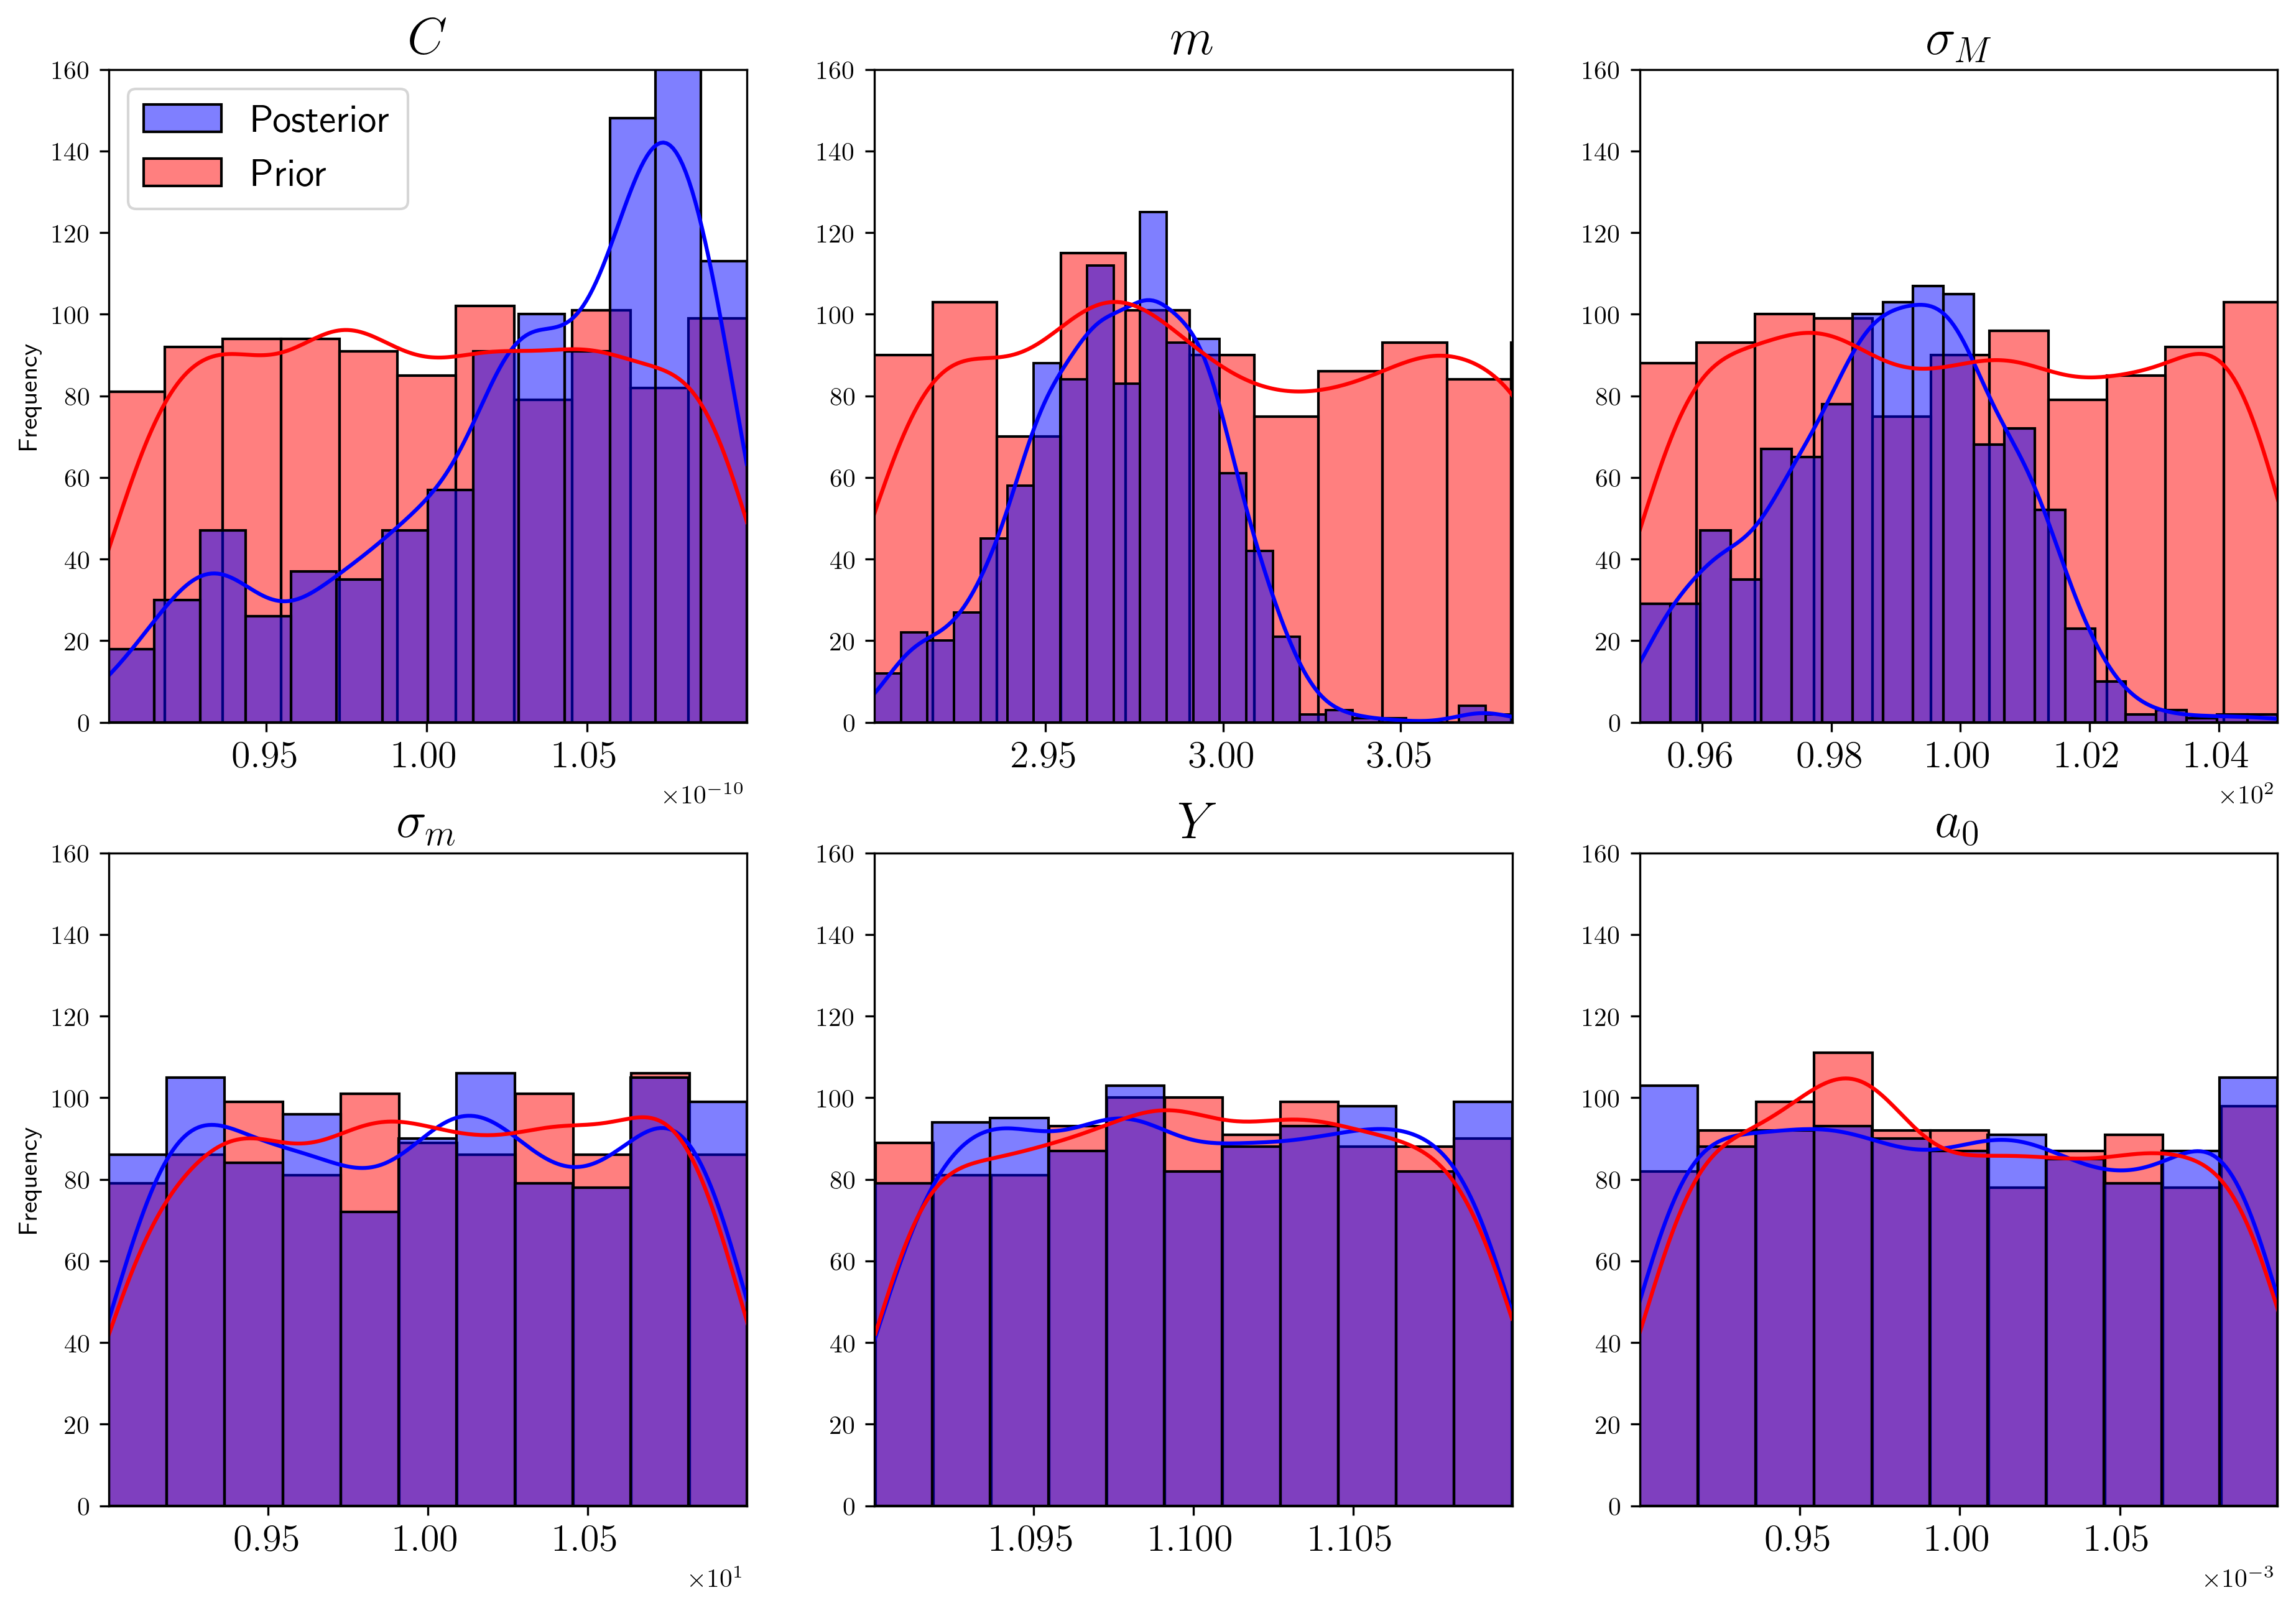

In [79]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    if i == 0:
        sns.histplot(posterior_df.iloc[:, i], ax=axs[i // 3, i % 3], kde=True, color='blue', label='Posterior', zorder=1)
        sns.histplot(prior_df.iloc[:, i], ax=axs[i // 3, i % 3], kde=True, color='red', label='Prior', zorder=0)
        axs[i // 3, i % 3].legend(fontsize=15)
    else:
        sns.histplot(posterior_df.iloc[:, i], ax=axs[i // 3, i % 3], kde=True, color='blue', zorder=1)
        sns.histplot(prior_df.iloc[:, i], ax=axs[i // 3, i % 3], kde=True, color='red', zorder=0)
    axs[i // 3, i % 3].set_title(posterior_df.columns[i], fontsize=20)
    axs[i // 3, i % 3].set_ylim(0, 160)
    axs[i // 3, i % 3].set_xlim(posterior_df.iloc[:, i].min(), posterior_df.iloc[:, i].max())
    axs[i // 3, i % 3].set_xlabel('')
    axs[i // 3, i % 3].set_ylabel('')
    axs[i // 3, i % 3].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axs[i // 3, i % 3].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    axs[i // 3, i % 3].tick_params(axis='x', labelsize=15)

axs[0, 0].set_ylabel('Frequency')
axs[1, 0].set_ylabel('Frequency')

In [37]:
rul_before, rul_after = [], []
for i in range(n_max):
    N_values, a_values = res[i]
    rul_before.append(N_values[-1])
    N_values, a_values = doe[i]
    rul_after.append(N_values[-1])
rul_before, rul_after = np.asarray(rul_before), np.asarray(rul_after)

In [38]:
rul_df = pd.DataFrame({'RUL before': rul_before, 'RUL after': rul_after})

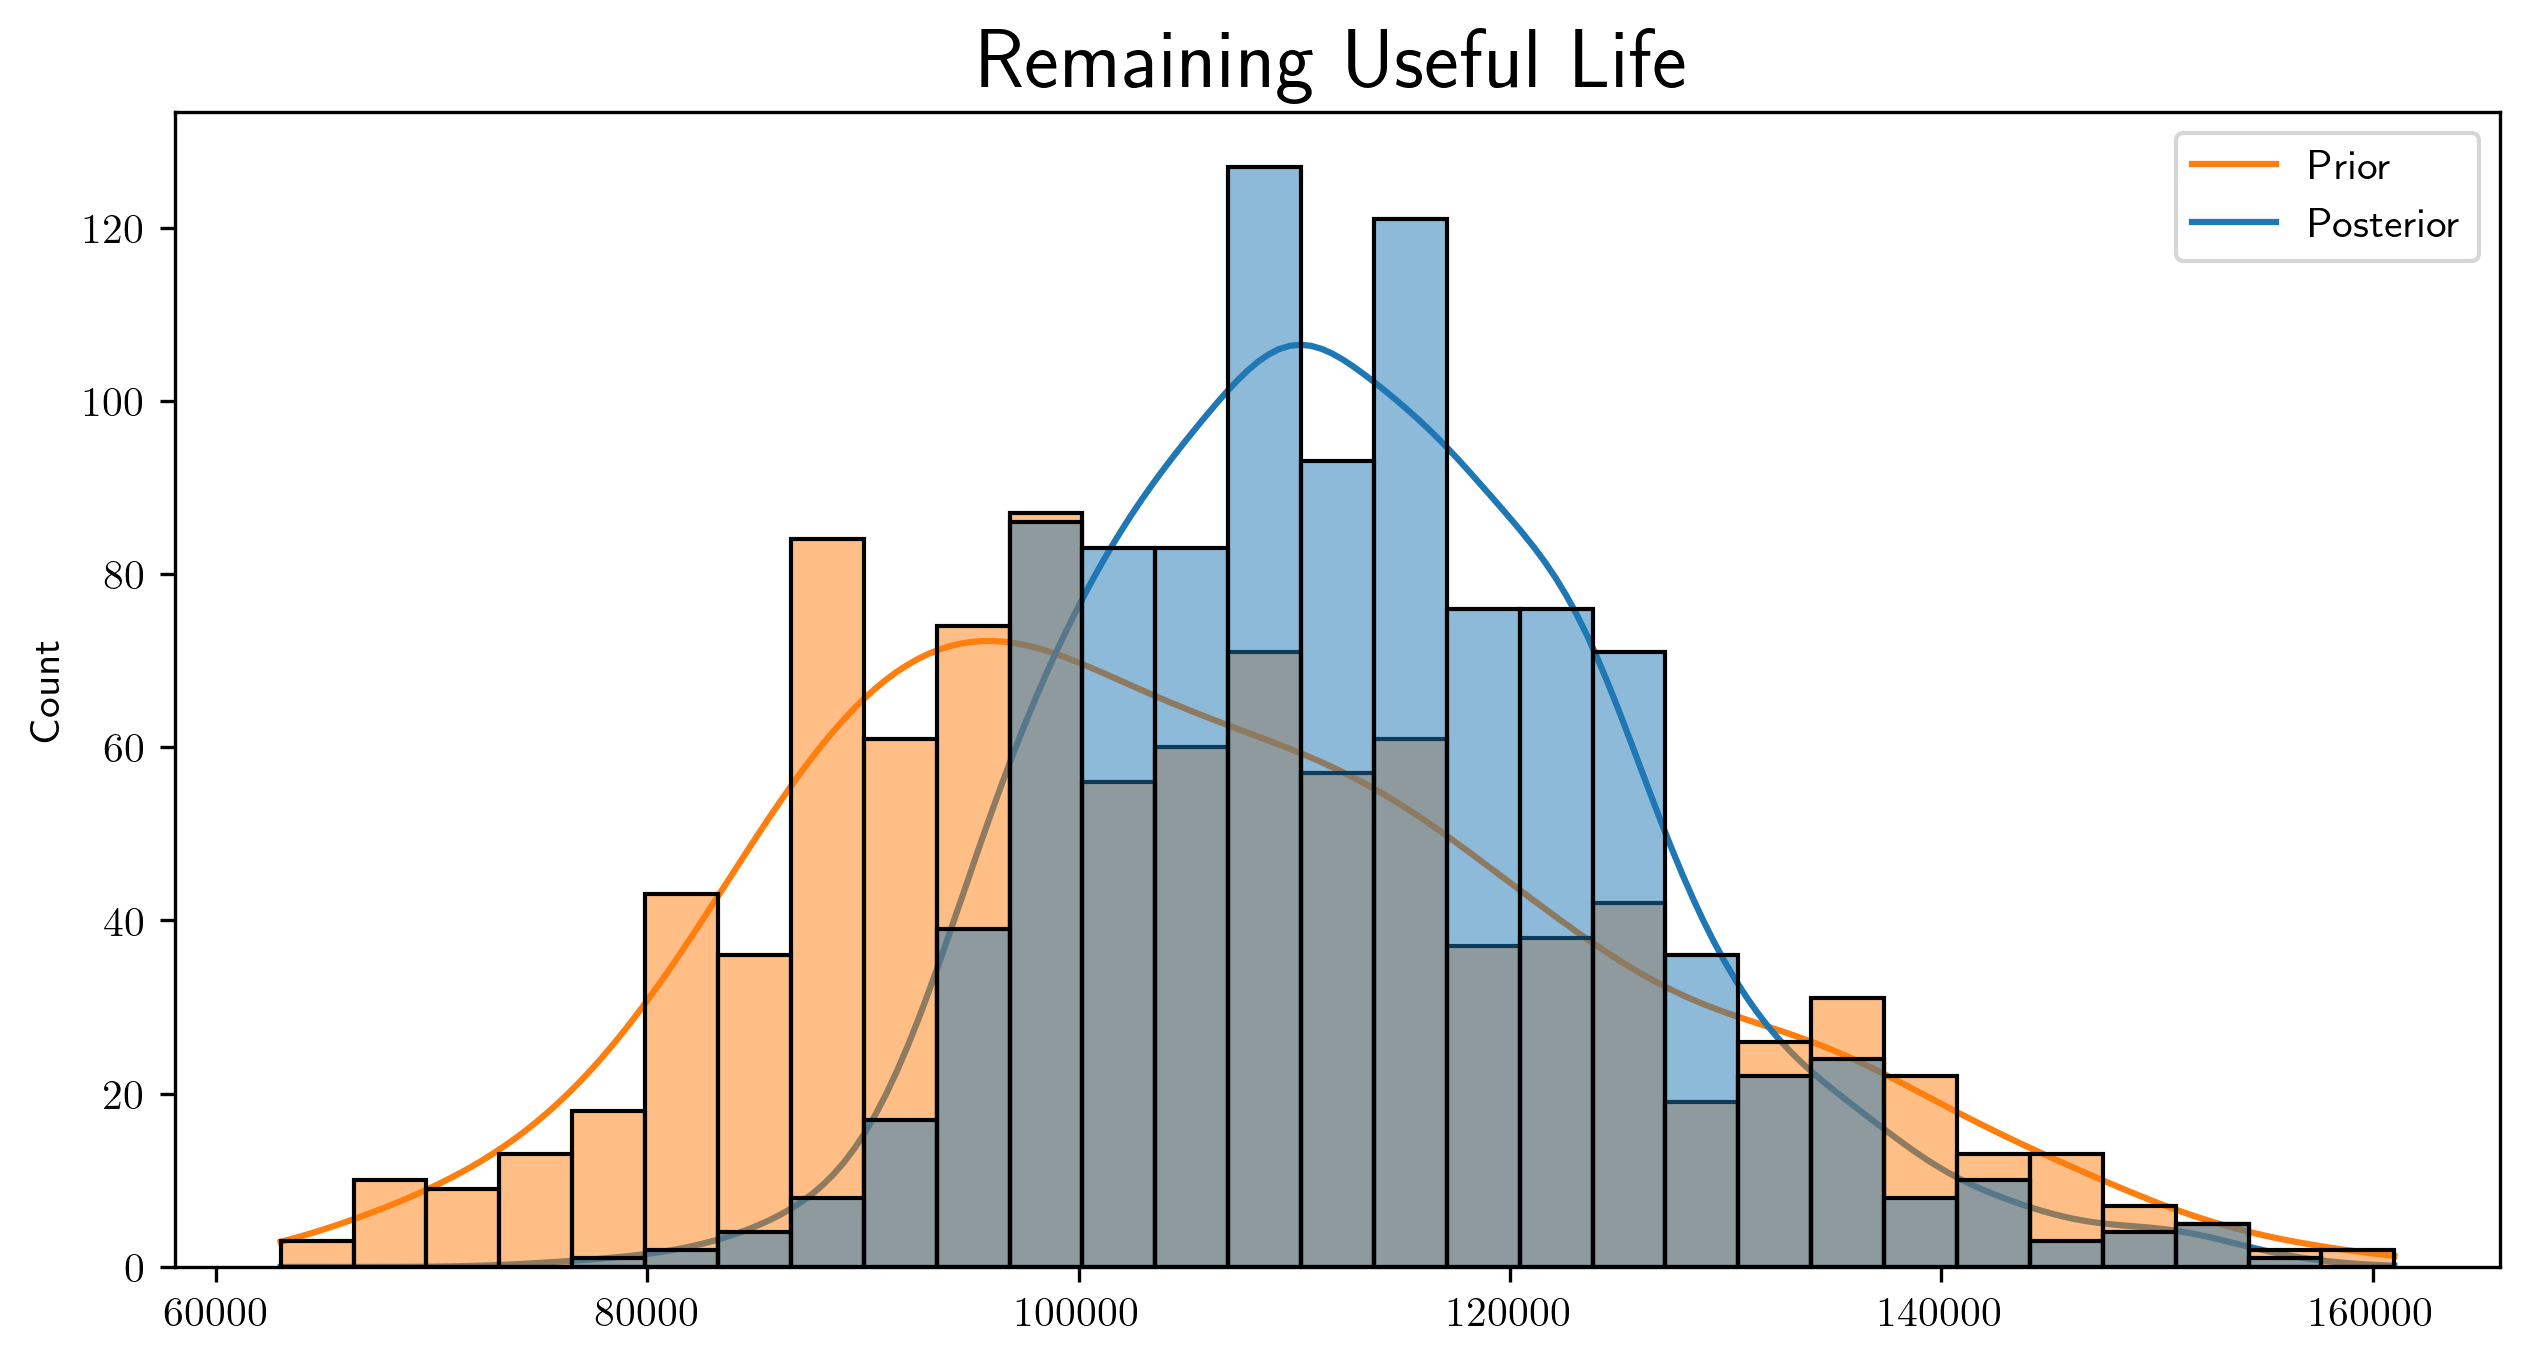

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(rul_df, ax=ax, kde=True, color='blue', zorder=10)
ax.set_title('Remaining Useful Life', fontsize=20) 
ax.legend(['Prior', 'Posterior'], fontsize=10)


# RUL visualization

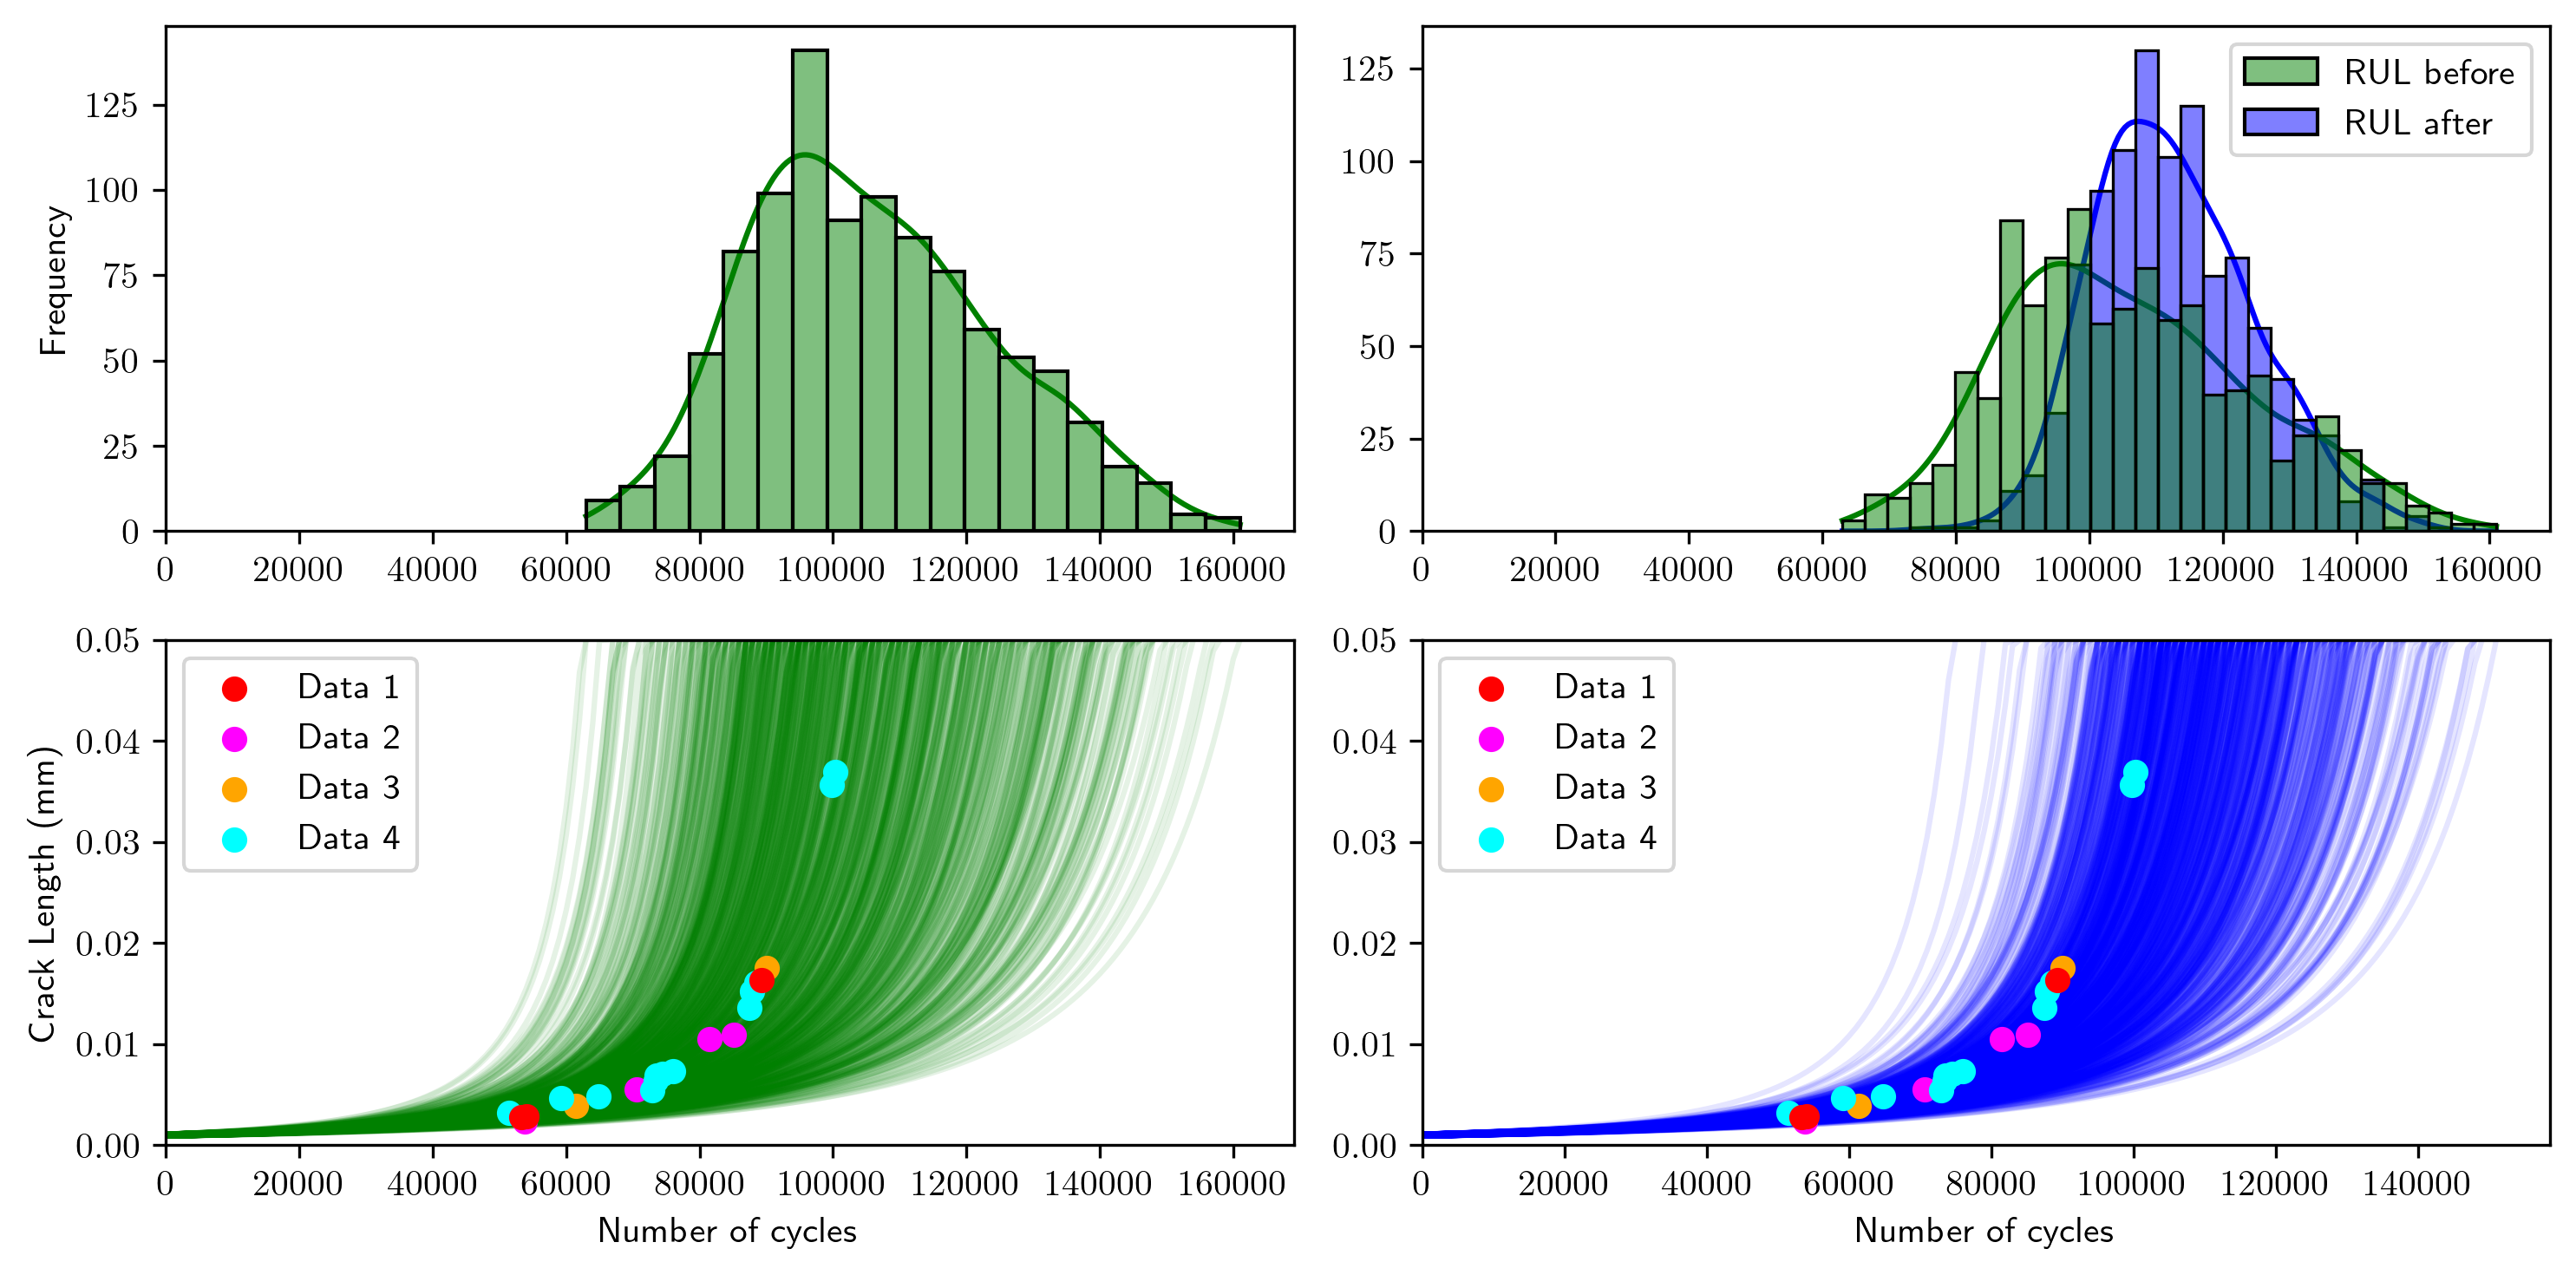

In [80]:
res = []
X = prior.getSample(n_max)

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

for i in range(n_max):
    C, m, sigma_max, sigma_min, Y, a0 = X[i]
    #N_values, a_values = paris_model(X[i])
    N_values, a_values = paris_crack_growth(N_cycles, delta_N, a_max, C, m, sigma_max, sigma_min, Y, a0)
    res.append([N_values, a_values])
    axs[1, 0].plot(doe[i][0], doe[i][1], color='green', alpha=0.1)
    axs[1, 1].plot(N_values, a_values, color='blue', alpha=0.1)

rul_before, rul_after = [], []
for i in range(n_max):
    N_values, a_values = doe[i]
    rul_before.append(N_values[-1])
    N_values, a_values = res[i]
    rul_after.append(N_values[-1])
rul_before, rul_after = np.asarray(rul_before), np.asarray(rul_after)

rul_df = pd.DataFrame({'RUL before': rul_before, 'RUL after': rul_after})

sns.histplot(rul_df['RUL before'], ax=axs[0, 0], kde=True, color='green', zorder=10)
sns.histplot(rul_df, ax=axs[0, 1], kde=True, palette=['green','blue'], zorder=10)

colors = ['red',  'cyan', 'orange', 'magenta']

for i in range(len(data)):
    if i == 0:
        axs[1, 0].scatter(data[i][0], data[i][1],  label=f'Data {i+1}', zorder=10, color=colors[-i])
        axs[1, 1].scatter(data[i][0], data[i][1],  label=f'Data {i+1}', zorder=10, color=colors[-i])
    else:
        axs[1, 0].scatter(data[i][0], data[i][1],  label=f'Data {i+1}', zorder=i+5, color=colors[-i])
        axs[1, 1].scatter(data[i][0], data[i][1],  label=f'Data {i+1}', zorder=i+5, color=colors[-i])

axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Frequency')
axs[0, 1].set_ylabel('')


axs[1, 0].set_xlim(0) 
axs[1, 0].set_ylim(0, 0.05)
axs[1, 0].legend()
axs[1, 0].set_xlabel("Number of cycles")
axs[1, 0].set_ylabel("Crack Length (mm)")

axs[1, 1].set_xlim(0)
axs[1, 1].set_ylim(0, 0.05)
axs[1, 1].legend()
axs[1, 1].set_xlabel("Number of cycles")
axs[1, 1].set_ylabel("")

axs[0, 0].set_xlim(axs[1, 0].get_xlim())
axs[0, 1].set_xlim(axs[1, 0].get_xlim())


#fig.suptitle(r"Paris-Erdogan's Law prior and posterior RUL$(D)$ evaluation with $D=5.0$ cm", fontsize=15)
plt.tight_layout()